Text(0.5, 0, 'Above-Ground Biomass (Mt C)')

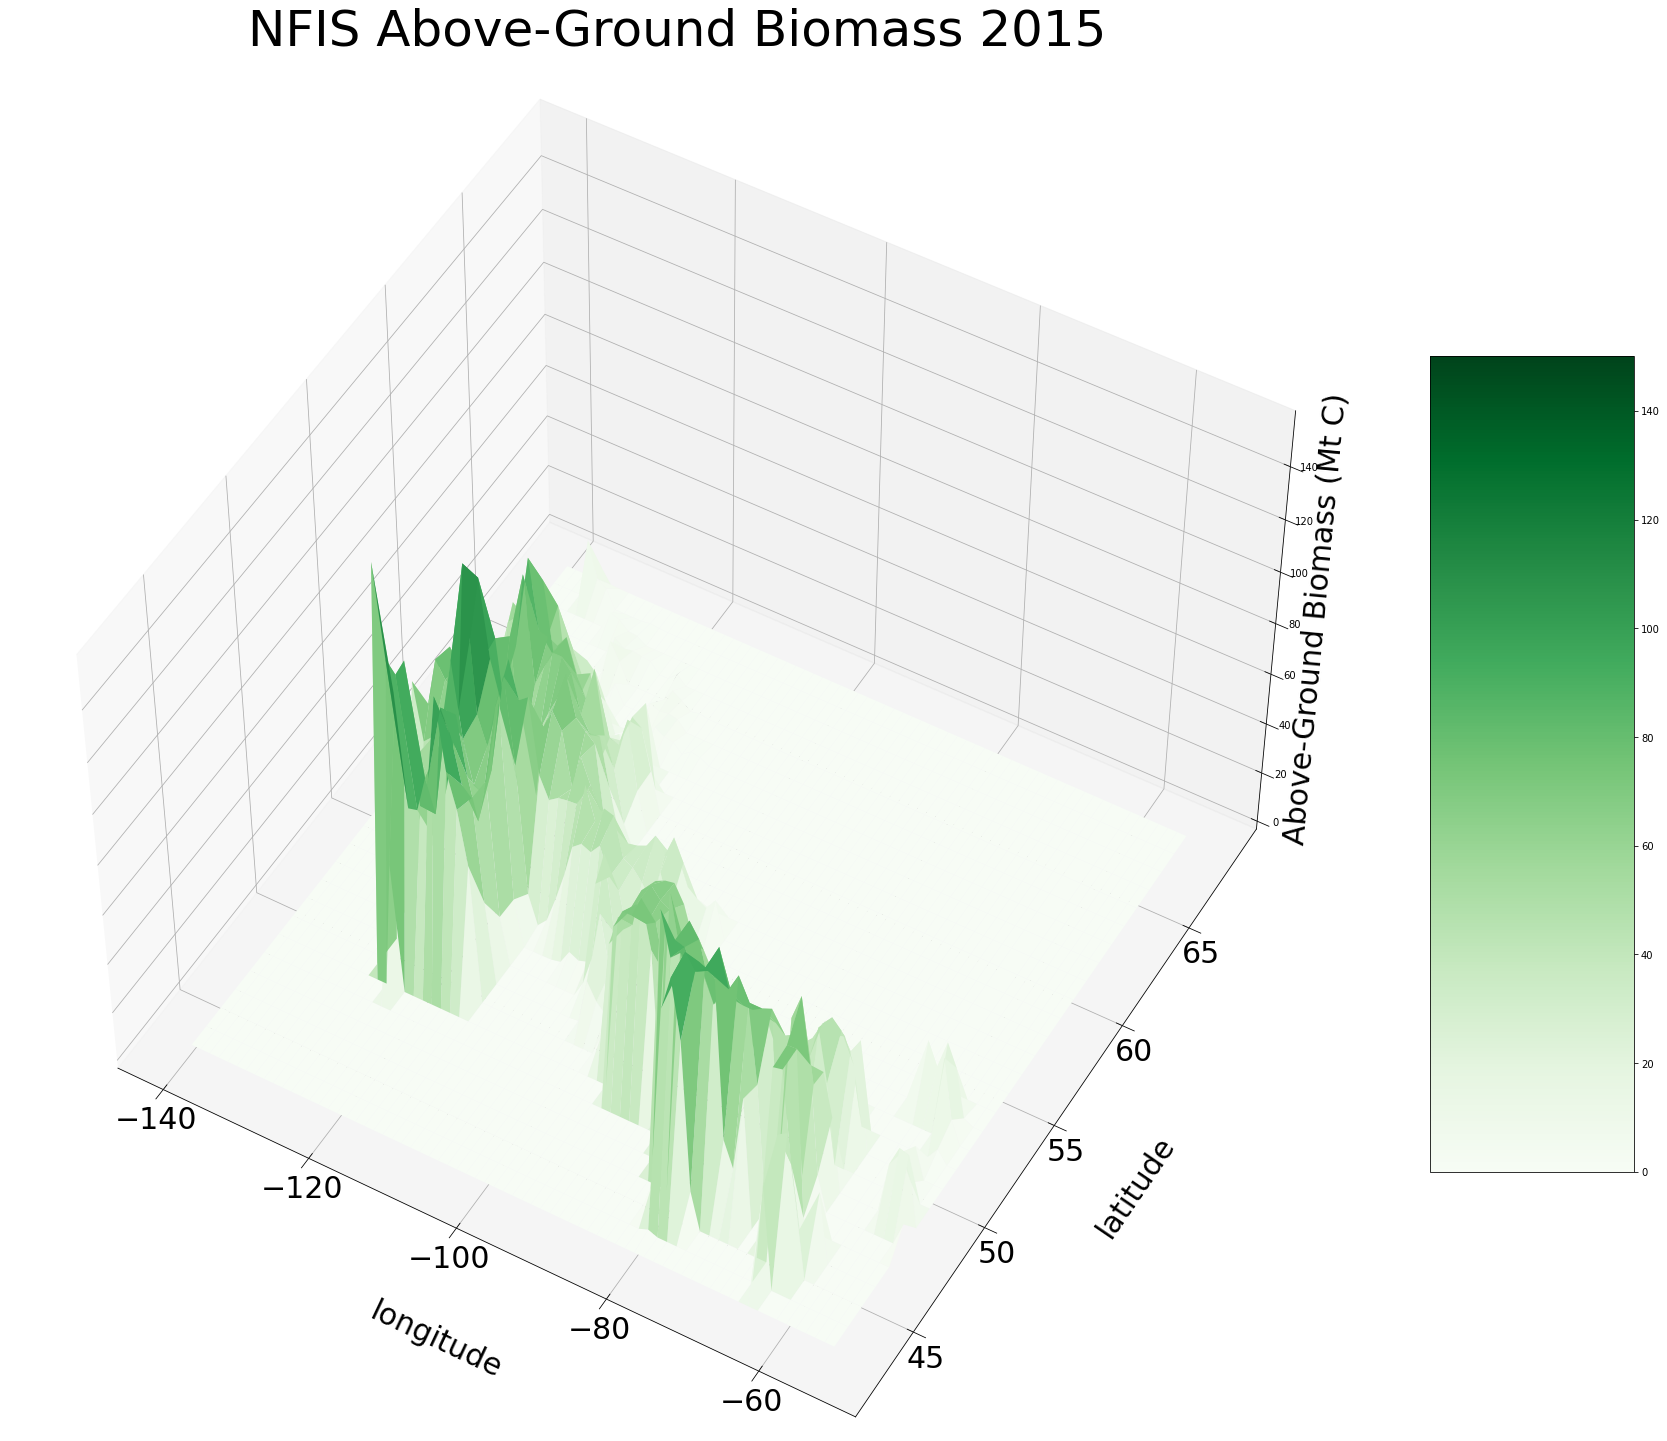

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from preprocessing.utils import getArea

nfis_data = pd.read_csv('../data/nfis_agb.csv')
from hydra import initialize, compose

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="ann_config")
#convert to kg/m2
nfis_data['agb'] = nfis_data['agb'] / 10 #ha to m2
nfis_data['area'] = nfis_data.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1)

nfis_data['agb'] = nfis_data['agb'] * nfis_data['area'] / 1e9 #to megatonnes

# reforested = reforested[reforested['year'] == 2015]
grid = nfis_data.pivot_table('agb', 'lon', 'lat', fill_value=0).to_numpy()

lat,lon = np.meshgrid(nfis_data['lat'].unique(),np.sort(nfis_data['lon'].unique()))

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
surf = ax.plot_surface(lon,lat, grid,cmap='Greens',rstride=1,cstride=1,vmin=0,vmax=150)
fig.colorbar(surf, shrink=0.5, aspect=4)
ax.figure.set_size_inches(30,30)
ax.view_init(50, -60)
ax.set_ylabel('latitude',fontsize=30,labelpad=50)
ax.set_xlabel('longitude',fontsize=30,labelpad=50)
ax.set_title('NFIS Above-Ground Biomass 2015',fontsize=50,pad=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_zlabel('Above-Ground Biomass (Mt C)',fontsize=30)


Text(0.5, 0, 'Above-Ground Biomass (Mt C)')

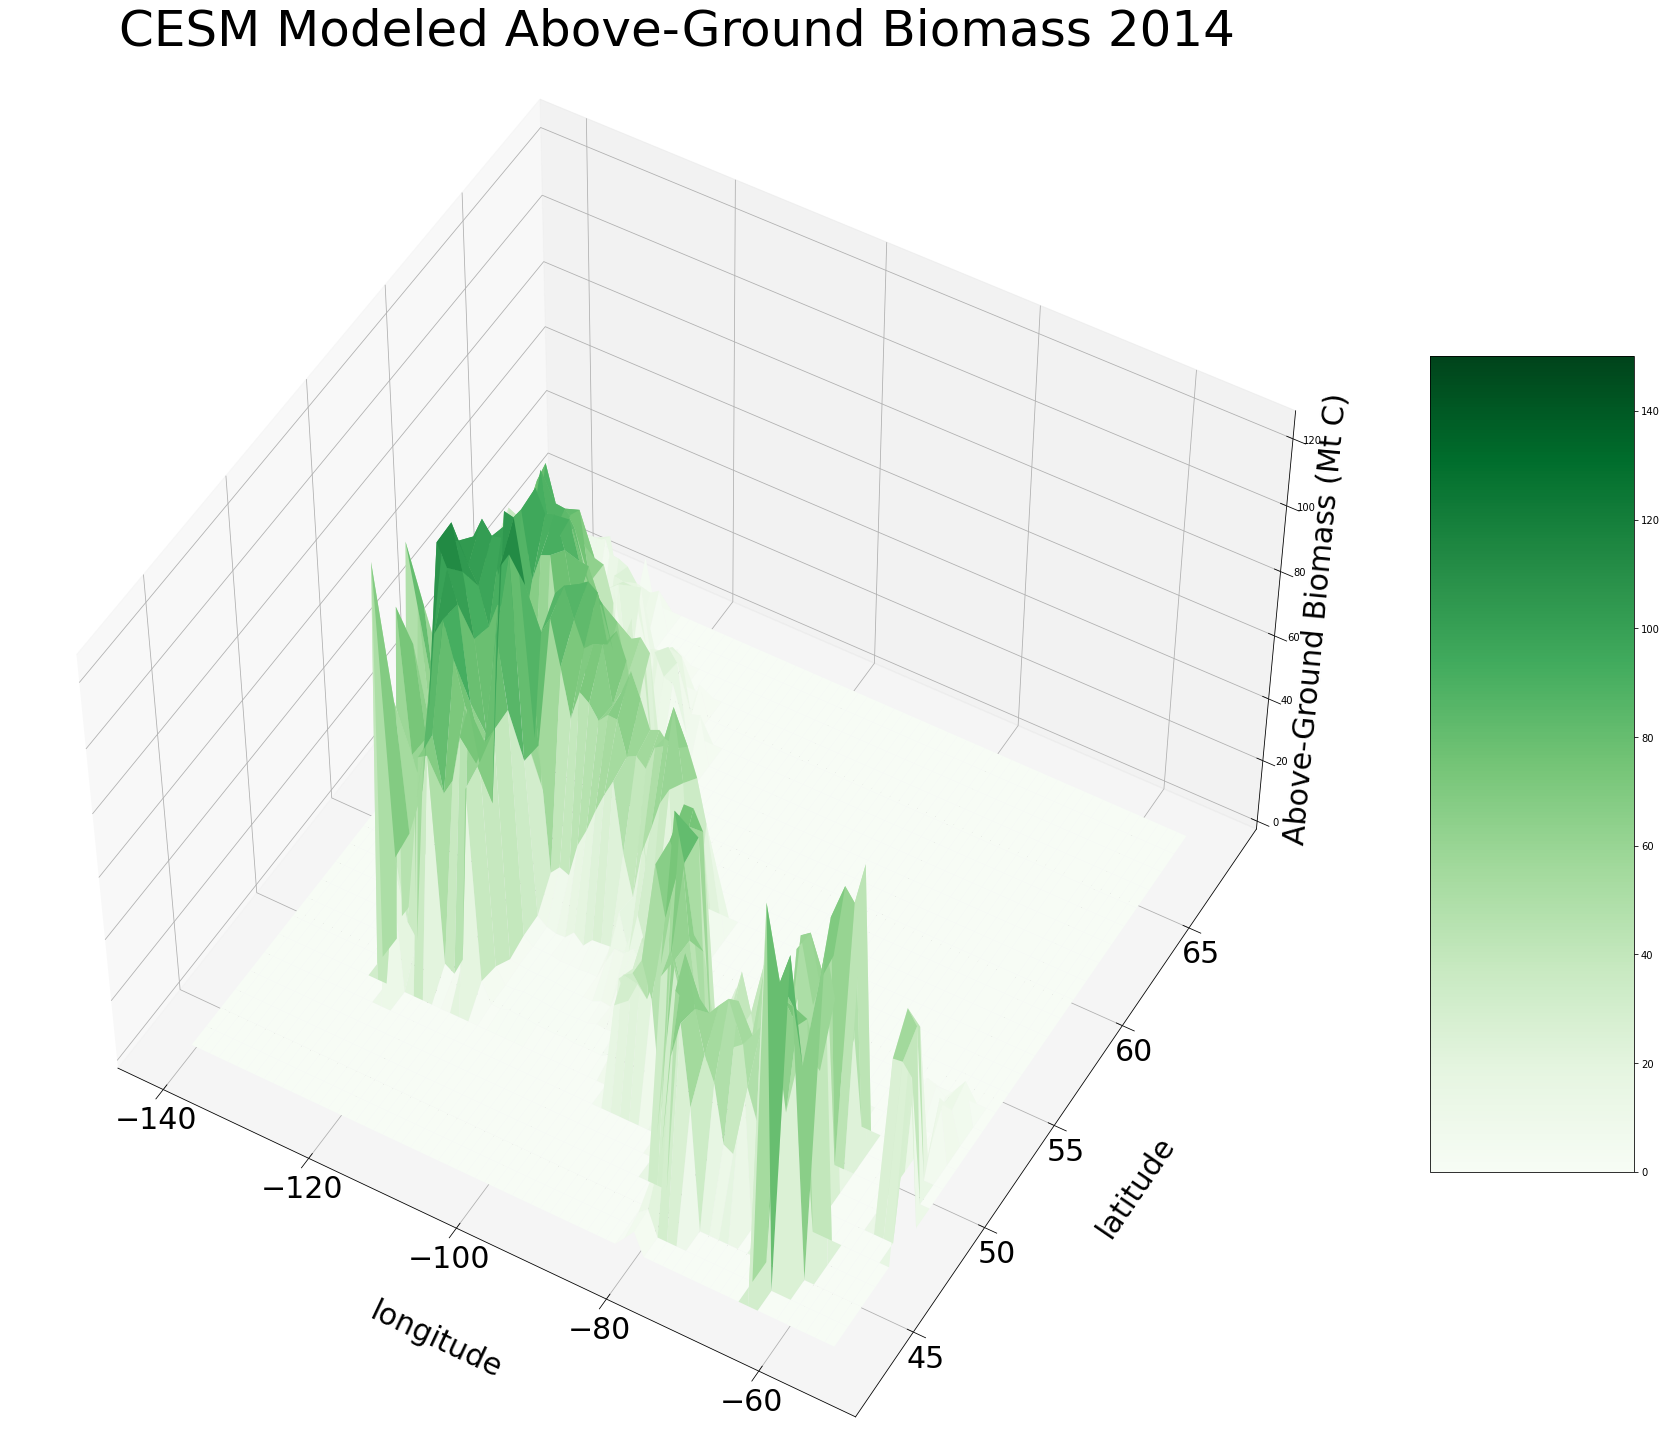

In [2]:
import pandas as pd

cesm_data = pd.read_csv('../data/cesm_data.csv')
cesm_data['agb'] = cesm_data['cStem'] + cesm_data['cOther'] + cesm_data['cLeaf']

cesm_data = cesm_data[cesm_data['# year'] == 2014]
cesm_data['area'] = cesm_data.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1)

cesm_data['agb'] = cesm_data['agb'] * cesm_data['area'] / 1e9 #to megatonnes
grid = cesm_data.pivot_table('agb', 'lon', 'lat', fill_value=0).to_numpy()

lat,lon = np.meshgrid(cesm_data['lat'].unique(),np.sort(cesm_data['lon'].unique()))

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
surf = ax.plot_surface(lon,lat, grid,cmap='Greens',rstride=1,cstride=1,vmin=0,vmax=150)
fig.colorbar(surf, shrink=0.5, aspect=4)

ax.figure.set_size_inches(30,30)
ax.view_init(50, -60)
ax.set_ylabel('latitude',fontsize=30,labelpad=50)
ax.set_xlabel('longitude',fontsize=30,labelpad=50)
ax.set_title('CESM Modeled Above-Ground Biomass 2014',fontsize=50,pad=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_zlabel('Above-Ground Biomass (Mt C)',fontsize=30)

/Users/gclyne/thesis/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


     # year        lat     lon    cOther      cCwd       cVeg   cLitter  \
0    2014.0  42.879582  -81.25  0.167658  0.089295   0.416675  0.230835   
1    2014.0  42.879582  -80.00  0.208436  0.188369   0.793676  0.182575   
2    2014.0  43.821991  -81.25  0.211987  0.191093   0.696717  0.323219   
3    2014.0  43.821991  -80.00  0.197966  0.274288   1.103832  0.358834   
4    2014.0  43.821991  -65.00  0.341009  2.923297  15.628346  0.503441   
..      ...        ...     ...       ...       ...        ...       ...   
508  2014.0  67.382202 -125.00  0.723231  1.375525   2.788731  0.859531   
509  2014.0  68.324608 -136.25  0.847651  0.762298   2.488773  0.682530   
510  2014.0  68.324608 -135.00  0.647509  1.608790   3.268773  0.770366   
511  2014.0  68.324608 -133.75  0.795586  1.517957   3.763496  0.744189   
512  2014.0  68.324608 -128.75  0.888326  1.102187   3.258849  0.784485   

        cLeaf     cRoot  evspsblsoi  ...  wetlandFrac             ps  \
0    0.036207  0.067286    

Text(0.5, 0, 'Above-Ground Biomass (Mt C)')

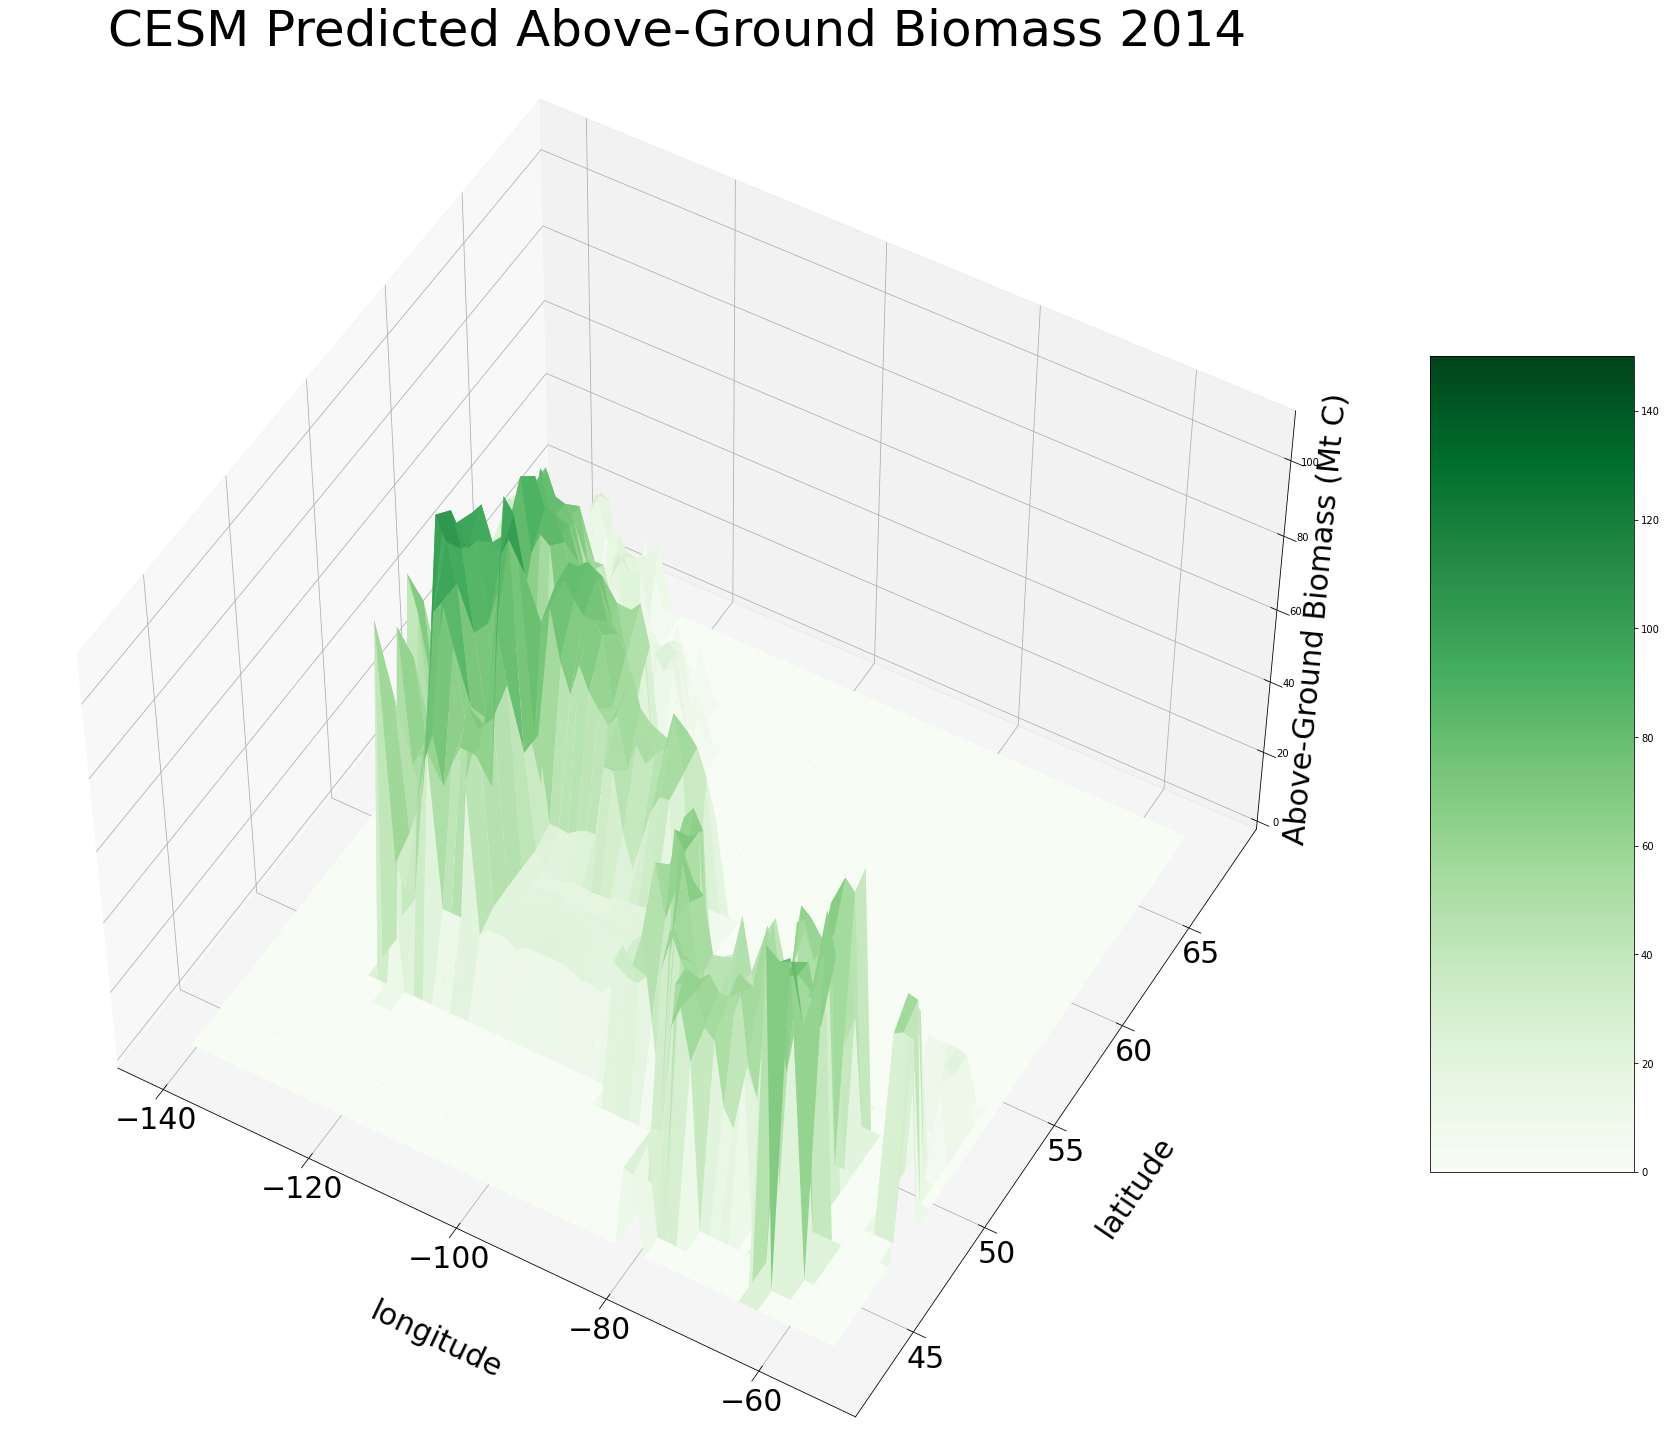

In [3]:
import pandas as pd
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import numpy as np
from pickle import load
import torch as T
import sys
sys.path.append('..')
from ann.ann_model import Net,CMIPDataset
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="ann_config")

final_input = cesm_data[cesm_data['# year'] == 2014].reset_index(drop=True)
print(final_input)
final_input = final_input[cfg.model.input + ['# year','lat','lon']]
scaler = load(open(f'{cfg.path.project}/checkpoint/ann_scaler.pkl', 'rb'))
scaled_input = scaler.transform(final_input.loc[:,cfg.model.input])
model = Net(len(cfg.model.input),len(cfg.model.output))

checkpoint = T.load(f'{cfg.path.project}/checkpoint/ann_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
ds = CMIPDataset(scaled_input,len(cfg.model.input),len(cfg.model.output))
batch_size = 128
ldr = T.utils.data.DataLoader(ds,batch_size=batch_size,shuffle=False)
results = []
model.eval()
for X in ldr:
    y = model(X[0].float())
    results.extend(y.detach().numpy())        
results_df = pd.DataFrame(results)
results_df['year'] = final_input['# year']
print(final_input['# year'])
print(results_df['year'])
results_df['lat'] = final_input['lat']
results_df['lon'] = final_input['lon']
results_df.columns = cfg.model.output + ['year','lat','lon']





results_df['agb'] = results_df['cStem'] + results_df['cOther'] + results_df['cLeaf']
results_df = results_df[results_df['year'] == 2014]
results_df['area'] = results_df.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1)

results_df['agb'] = results_df['agb'] * results_df['area'] / 1e9 #to megatonnes
grid = results_df.pivot_table('agb', 'lon', 'lat', fill_value=0).to_numpy()

lat,lon = np.meshgrid(results_df['lat'].unique(),np.sort(results_df['lon'].unique()))

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
surf = ax.plot_surface(lon,lat, grid,cmap='Greens',rstride=1,cstride=1,vmin=0,vmax=150)
fig.colorbar(surf, shrink=0.5, aspect=4)
ax.figure.set_size_inches(30,30)
ax.view_init(50, -60)
ax.set_ylabel('latitude',fontsize=30,labelpad=50)
ax.set_xlabel('longitude',fontsize=30,labelpad=50)
ax.set_title('CESM Predicted Above-Ground Biomass 2014',fontsize=50,pad=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_zlabel('Above-Ground Biomass (Mt C)',fontsize=30)



Text(0.5, 0, 'Above-Ground Biomass (Mt C)')

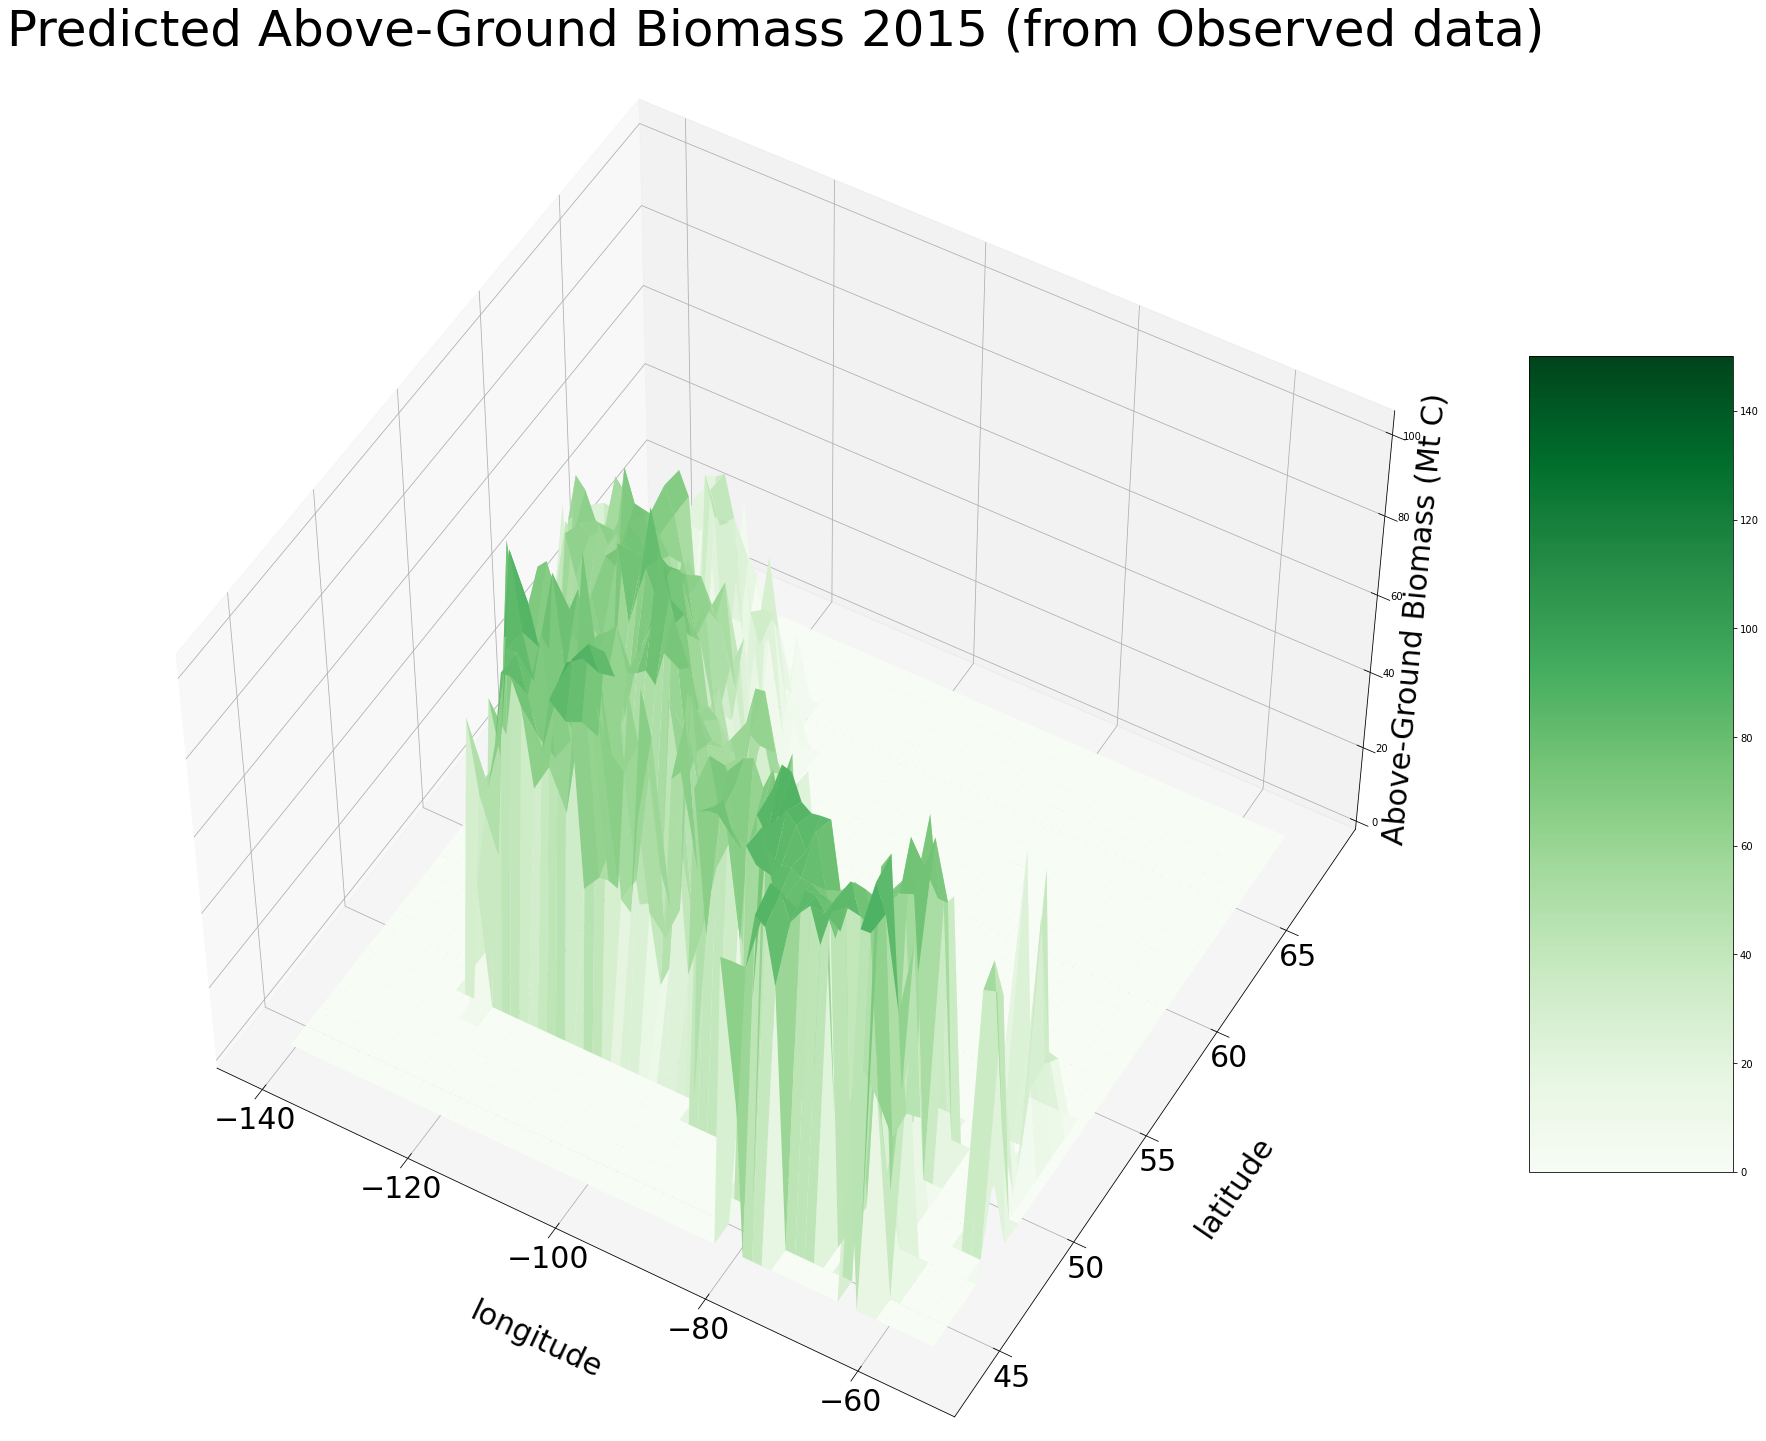

In [4]:

import pandas as pd

predictions = pd.read_csv(cfg.path.observed_estimates)
predictions['agb'] = predictions['cStem'] + predictions['cOther'] + predictions['cLeaf']
predictions = predictions[predictions['year'] == 2015]
predictions['area'] = predictions.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1)

predictions['agb'] = predictions['agb'] * predictions['area'] / 1e9 #to megatonnes
grid = predictions.pivot_table('agb', 'lon', 'lat', fill_value=0).to_numpy()
lat,lon = np.meshgrid(predictions['lat'].unique(),np.sort(predictions['lon'].unique()))

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
surf = ax.plot_surface(lon,lat, grid,cmap='Greens',rstride=1,cstride=1,vmin=0,vmax=150)
fig.colorbar(surf, shrink=0.5, aspect=4)

ax.figure.set_size_inches(30,30)
ax.view_init(50, -60)
ax.set_ylabel('latitude',fontsize=30,labelpad=50)
ax.set_xlabel('longitude',fontsize=30,labelpad=50)
ax.set_title('Predicted Above-Ground Biomass 2015 (from Observed data)',fontsize=50,pad=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_zlabel('Above-Ground Biomass (Mt C)',fontsize=30)

Text(0.5, 0, 'Above-Ground Biomass (Mt C)')

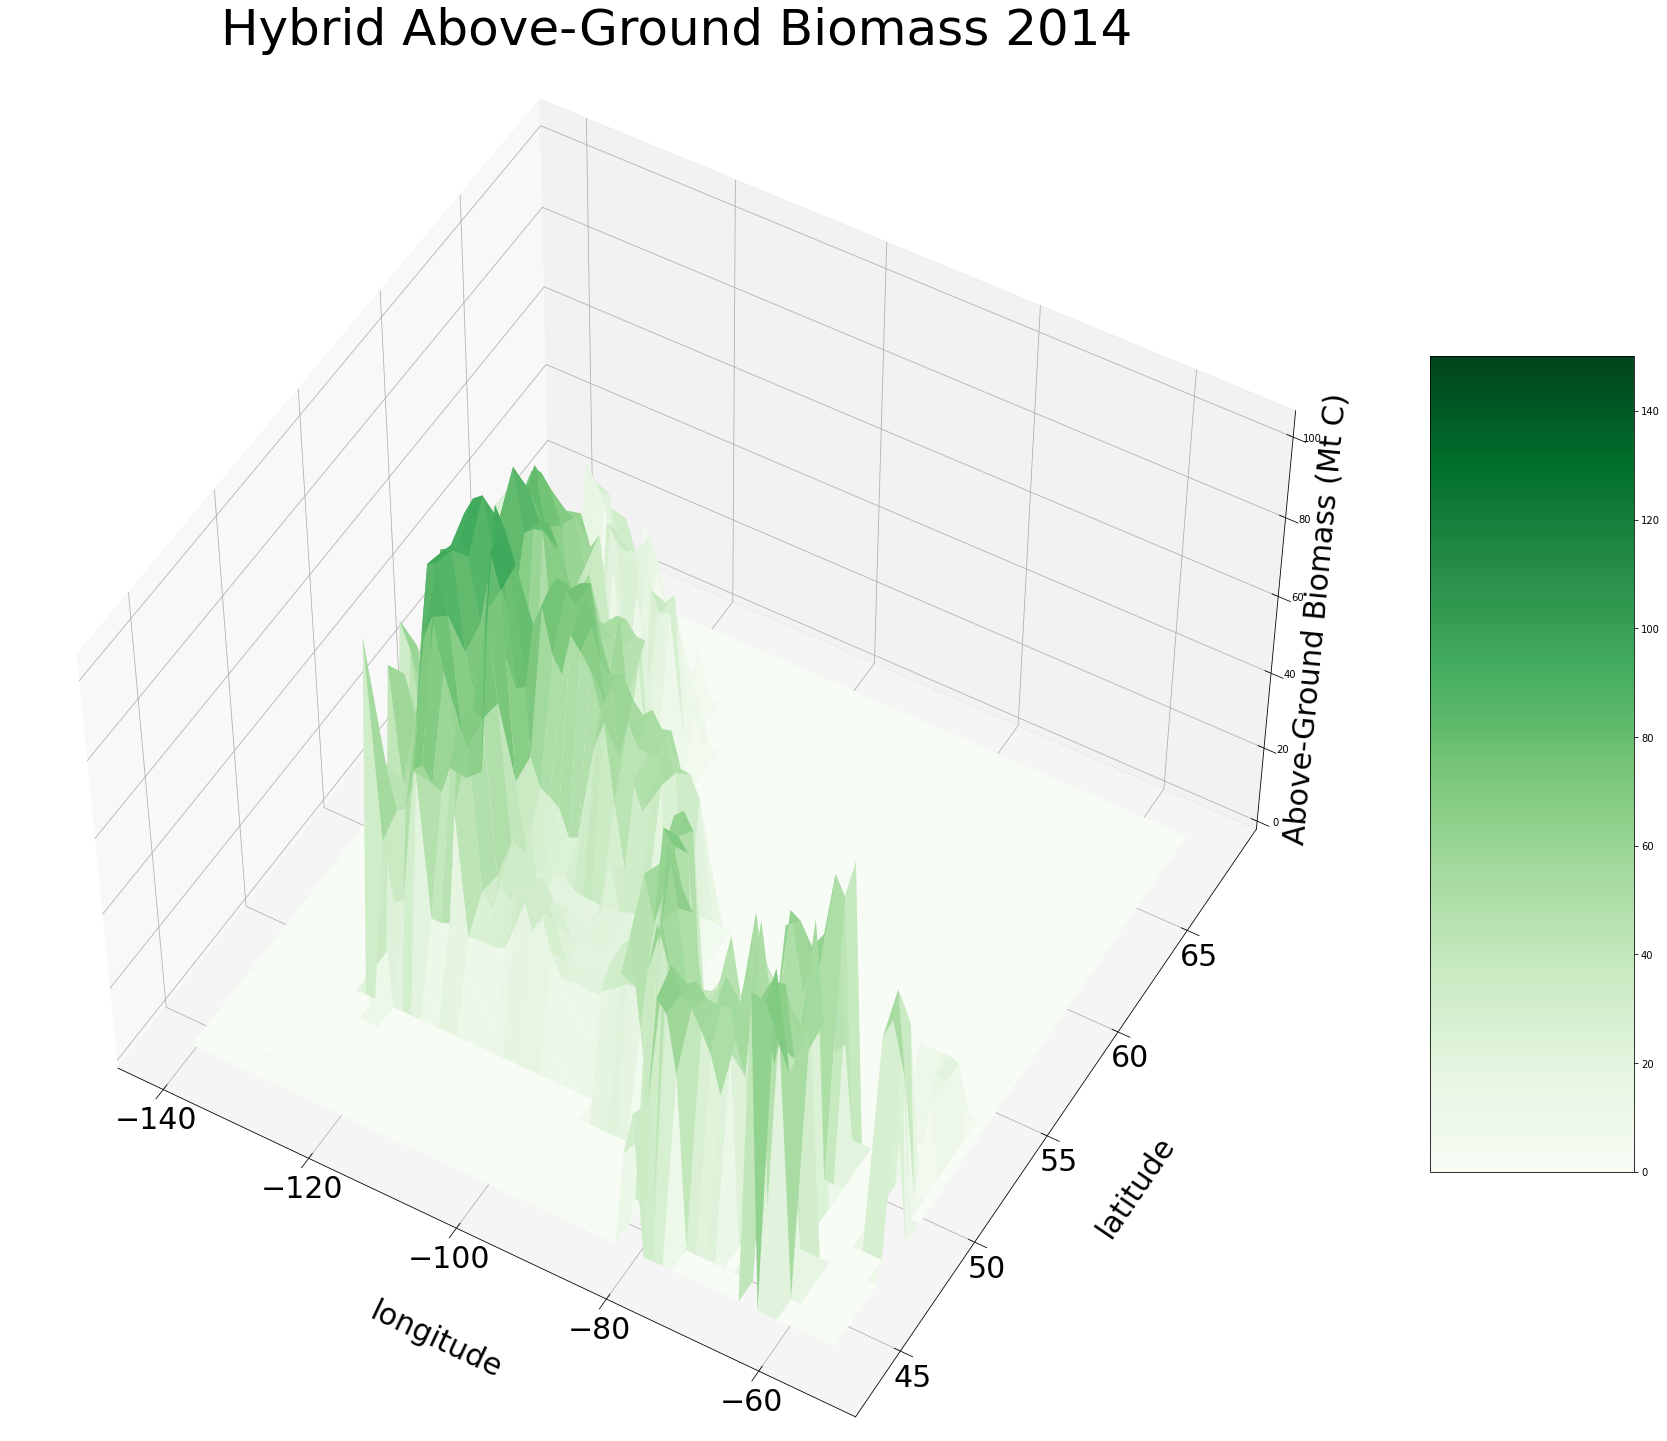

In [5]:

import pandas as pd

hybrid = pd.read_csv('/Users/gclyne/thesis/data/hybrid_no_reforest.csv')
hybrid['agb'] = hybrid['cStem'] + hybrid['cOther'] + hybrid['cLeaf']
hybrid = hybrid[hybrid['year'] == 2014]
hybrid['area'] = hybrid.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1)

hybrid['agb'] = hybrid['agb'] * hybrid['area'] / 1e9 #to megatonnes
grid = hybrid.pivot_table('agb', 'lon', 'lat', fill_value=0).to_numpy()
lat,lon = np.meshgrid(hybrid['lat'].unique(),np.sort(hybrid['lon'].unique()))

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
surf = ax.plot_surface(lon,lat, grid,cmap='Greens',rstride=1,cstride=1,vmin=0,vmax=150)
fig.colorbar(surf, shrink=0.5, aspect=4)

ax.figure.set_size_inches(30,30)
ax.view_init(50, -60)
ax.set_ylabel('latitude',fontsize=30,labelpad=50)
ax.set_xlabel('longitude',fontsize=30,labelpad=50)
ax.set_title('Hybrid Above-Ground Biomass 2014',fontsize=50,pad=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_zlabel('Above-Ground Biomass (Mt C)',fontsize=30)

In [6]:
from preprocessing.utils import getArea
nfis_data['area'] = (nfis_data.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1))
nfis_data['agb'] = nfis_data['agb'] * nfis_data['area'] / 1e9

cesm_data['area'] = (cesm_data.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1))
cesm_data['agb'] = cesm_data['agb'] * cesm_data['area'] / 1e9

results_df['area'] = (results_df.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1))
results_df['agb'] = results_df['agb'] * results_df['area'] / 1e9

predictions['area'] = (predictions.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1))
predictions['agb'] = predictions['agb'] * predictions['area'] / 1e9

hybrid['area'] = (hybrid.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1))
hybrid['agb'] = hybrid['agb'] * hybrid['area'] / 1e9


cesm_comp = ((nfis_data['agb'].reset_index(drop=True) - cesm_data['agb'].reset_index(drop=True)) ** 2).mean() ** .5
pred_comp = ((nfis_data['agb'].reset_index(drop=True) - results_df['agb'].reset_index(drop=True)) ** 2).mean() ** .5
pred_comp_obs = ((nfis_data['agb'].reset_index(drop=True) - predictions['agb'].reset_index(drop=True)) ** 2).mean() ** .5
hybrid_comp_obs = ((nfis_data['agb'].reset_index(drop=True) - hybrid['agb'].reset_index(drop=True)) ** 2).mean() ** .5


print(cesm_comp,pred_comp,pred_comp_obs,hybrid_comp_obs)

246.55089051899617 229.63557867766087 282.0279843266815 247.34117454587997


In [7]:
import sys
sys.path.append('..')
from preprocessing.utils import getArea

nfis_total = (nfis_data.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1) * nfis_data['agb'] / 1e9).sum() #kg to megatonnes
cesm_total = (cesm_data.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1) * cesm_data['agb'] / 1e9).sum()# kg to megatonnes
observed_pred_total = (predictions.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1) * predictions['agb'] / 1e9).sum() #to megatonnes
hold_out_total = (results_df.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1) * results_df['agb'] / 1e9).sum() #to megatonnes
hybrid_agb_total = (hybrid.apply(lambda x: getArea(x['lat'],x['lon'],cfg),axis=1) * hybrid['agb'] / 1e9).sum() #to megatonnes

print(nfis_total,cesm_total,observed_pred_total,hold_out_total,hybrid_agb_total)


1628871.9195679496 1740086.6738522644 2276076.270919391 1808178.8290828438 1789227.7268348425
